<a href="https://colab.research.google.com/github/EmmanuelColonPalacios/Proyecto-ColonRoldan-ComputacionGrafica/blob/main/ProyectoFinal_EmmanuelCol%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proyecto Final de PLN - Emmanuel Colón Palacios - FI UNAM - 317254523

In [ ]:
!pip install nltk
!pip install transformers
!pip install matplotlib seaborn
!pip install transformers torch
!pip install torch
!pip install transformers
!pip install scikit-learn

In [2]:
import nltk #Librería stopwords
nltk.download('stopwords')
nltk.download('punkt')
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
annotations_df = pd.read_csv('sexism_annotations.csv')
print(annotations_df.head())
print(annotations_df.columns)


   phrasing  content  worker    id
0         3        2       0  1815
1         3        6       1  1815
2         3        6       2  1815
3         3        6       3  1815
4         3        6       4  1815
Index(['phrasing', 'content', 'worker', 'id'], dtype='object')


In [4]:
data_df = pd.read_csv('sexism_data.csv')
print(data_df.head())
print(data_df.columns)


   id dataset                                               text  toxicity  \
0   0   other  MENTION3481 i didn't even know random was an o...  0.118180   
1   1   other                   Bottom two should've gone!  #mkr  0.251850   
2   2  callme  MENTION3111 MENTION3424 ladyboner deserves so ...  0.113331   
3   3   other  She shall now be known as Sourpuss #MKR #KatAn...  0.531153   
4   4   other  Tarah W threw a bunch of women under the bus s...  0.118718   

   sexist  of_id  
0   False     -1  
1   False     -1  
2   False     -1  
3   False     -1  
4   False     -1  
Index(['id', 'dataset', 'text', 'toxicity', 'sexist', 'of_id'], dtype='object')


#Filtración de columas relevantes

In [5]:
data_df = data_df[['text', 'sexist']]

Exploración de distribución de etiquetas

In [6]:
#Distribución de etiquetas
print(data_df['sexist'].value_counts())

False    11822
True      1809
Name: sexist, dtype: int64


Preprocesamiento de Texto

In [7]:
def preprocess_text(text):
    # Eliminar caracteres no alfabéticos y convertir a minúsculas
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    # Tokenizar y eliminar stopwords
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# Aplicar preprocesamiento al conjunto de datos
data_df['text'] = data_df['text'].apply(preprocess_text)

In [8]:
# Dividir el conjunto de datos en entrenamiento y prueba
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42, stratify=data_df['sexist'])

# Representación numérica de los textos usando Bag of Words (BoW)
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df['text'])
X_test = vectorizer.transform(test_df['text'])

# Codificación de las etiquetas (sexist y no sexist) a valores numéricos
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['sexist'])
y_test = label_encoder.transform(test_df['sexist'])

In [9]:
# Inicializar el modelo de regresión logística
model = LogisticRegression(random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy on test set: {accuracy:.2f}')

# Mostrar métricas detalladas
print(classification_report(y_test, predictions, target_names=['Not Sexist', 'Sexist']))


Accuracy on test set: 0.91
              precision    recall  f1-score   support

  Not Sexist       0.93      0.96      0.95      2365
      Sexist       0.69      0.53      0.60       362

    accuracy                           0.91      2727
   macro avg       0.81      0.75      0.77      2727
weighted avg       0.90      0.91      0.90      2727



Incorporamos anotaciones adicionales de la dataset

In [10]:
# Cargar el conjunto de datos original
original_data_df = pd.read_csv('sexism_data.csv')

# Cargar el conjunto de datos de anotaciones
annotations_df = pd.read_csv('sexism_annotations.csv')

# Conservar solo las columnas relevantes para nuestro modelo
annotations_df = annotations_df[['id', 'phrasing', 'content']]

# Fusionar los conjuntos de datos de datos y anotaciones usando la columna "id"
merged_df = pd.merge(original_data_df, annotations_df, on='id', how='inner')

# Preprocesamiento de Texto
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

merged_df['text'] = merged_df['text'].apply(preprocess_text)

# Dividir el conjunto de datos fusionado en entrenamiento y prueba
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42, stratify=merged_df['sexist'])

# Representación numérica de los textos usando Bag of Words (BoW)
vectorizer = CountVectorizer()
X_train_text = vectorizer.fit_transform(train_df['text'])
X_test_text = vectorizer.transform(test_df['text'])

# Convertir las matrices dispersas a DataFrames
X_train_text_df = pd.DataFrame(X_train_text.toarray(), columns=vectorizer.get_feature_names_out())
X_test_text_df = pd.DataFrame(X_test_text.toarray(), columns=vectorizer.get_feature_names_out())

# Agregar las columnas "phrasing" y "content" como características adicionales
X_train = pd.concat([X_train_text_df, train_df[['phrasing', 'content']].reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test_text_df, test_df[['phrasing', 'content']].reset_index(drop=True)], axis=1)

# Codificación de las etiquetas (sexist y no sexist) a valores numéricos
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['sexist'])
y_test = label_encoder.transform(test_df['sexist'])

# Inicializar el modelo de regresión logística
model_with_annotations = LogisticRegression(random_state=42)

# Entrenar el modelo
model_with_annotations.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
predictions_with_annotations = model_with_annotations.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy_with_annotations = accuracy_score(y_test, predictions_with_annotations)
print(f'Accuracy on test set with annotations: {accuracy_with_annotations:.2f}')

# Mostrar métricas detalladas
print(classification_report(y_test, predictions_with_annotations, target_names=['Not Sexist', 'Sexist']))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on test set with annotations: 0.95
              precision    recall  f1-score   support

  Not Sexist       0.96      0.97      0.96      3837
      Sexist       0.93      0.91      0.92      1809

    accuracy                           0.95      5646
   macro avg       0.94      0.94      0.94      5646
weighted avg       0.95      0.95      0.95      5646



Integración de BERT como característica adicional al modelo existente.

In [ ]:
from transformers import BertTokenizer, BertModel
import numpy as np

original_data_df = pd.read_csv('sexism_data.csv')

annotations_df = pd.read_csv('sexism_annotations.csv')

annotations_df = annotations_df[['id', 'phrasing', 'content']]

merged_df = pd.merge(original_data_df, annotations_df, on='id', how='inner')

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

merged_df['text'] = merged_df['text'].apply(preprocess_text)

train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42, stratify=merged_df['sexist'])

# Tokenizar y obtener representaciones ocultas de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts):
    encoded_texts = tokenizer(texts.tolist(), return_tensors='pt', max_length=512, truncation=True, padding=True)
    with torch.no_grad():
        output = model(**encoded_texts)
    bert_embeddings = output.last_hidden_state.mean(dim=1).numpy()
    return bert_embeddings

# Obtener representación oculta de BERT para cada texto
bert_embeddings_train = get_bert_embeddings(train_df['text'])
bert_embeddings_test = get_bert_embeddings(test_df['text'])

# Convertir las representaciones ocultas de BERT a DataFrames
bert_df_train = pd.DataFrame(bert_embeddings_train)
bert_df_test = pd.DataFrame(bert_embeddings_test)

# Agregar las representaciones ocultas de BERT como características adicionales
X_train = pd.concat([bert_df_train, train_df[['phrasing', 'content']].reset_index(drop=True)], axis=1)
X_test = pd.concat([bert_df_test, test_df[['phrasing', 'content']].reset_index(drop=True)], axis=1)

# Codificación de las etiquetas (sexist y no sexist) a valores numéricos
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['sexist'])
y_test = label_encoder.transform(test_df['sexist'])

# Inicializar el modelo de regresión logística
model_with_bert = LogisticRegression(random_state=42)

# Entrenar el modelo
model_with_bert.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
predictions_with_bert = model_with_bert.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy_with_bert = accuracy_score(y_test, predictions_with_bert)
print(f'Accuracy on test set with BERT: {accuracy_with_bert:.2f}')

# Mostrar métricas detalladas
print(classification_report(y_test, predictions_with_bert, target_names=['Not Sexist', 'Sexist']))


Visualizaciones con matplotlib

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

únicamente con data_df

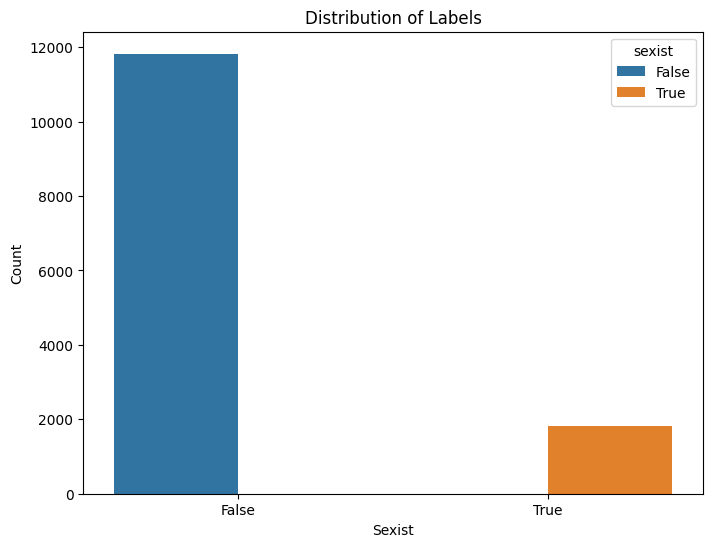

In [12]:
# Visualizar la distribución de etiquetas en merged_df
plt.figure(figsize=(8, 6))
sns.countplot(x='sexist', hue='sexist', data=data_df)
plt.title('Distribution of Labels')
plt.xlabel('Sexist')
plt.ylabel('Count')
plt.show()


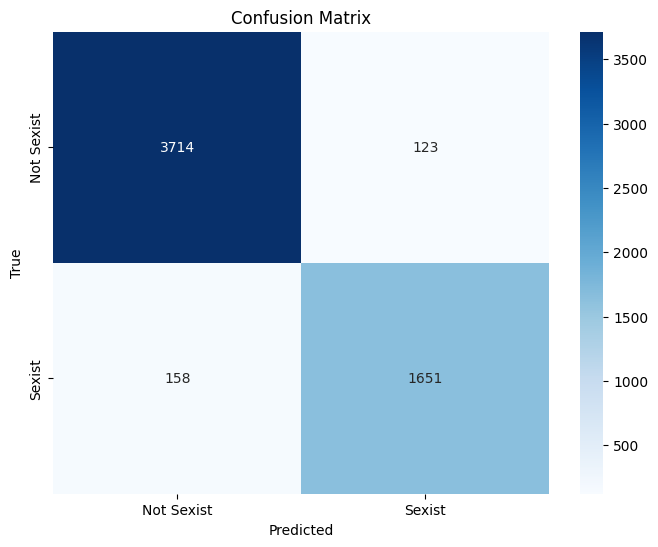

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, predictions_with_annotations)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sexist', 'Sexist'], yticklabels=['Not Sexist', 'Sexist'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

con merged_df

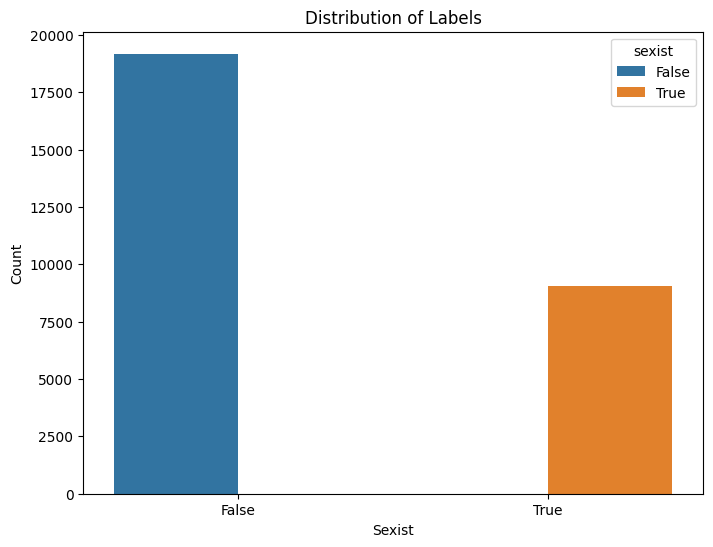

In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sexist', hue='sexist', data=merged_df)
plt.title('Distribution of Labels')
plt.xlabel('Sexist')
plt.ylabel('Count')
plt.show()

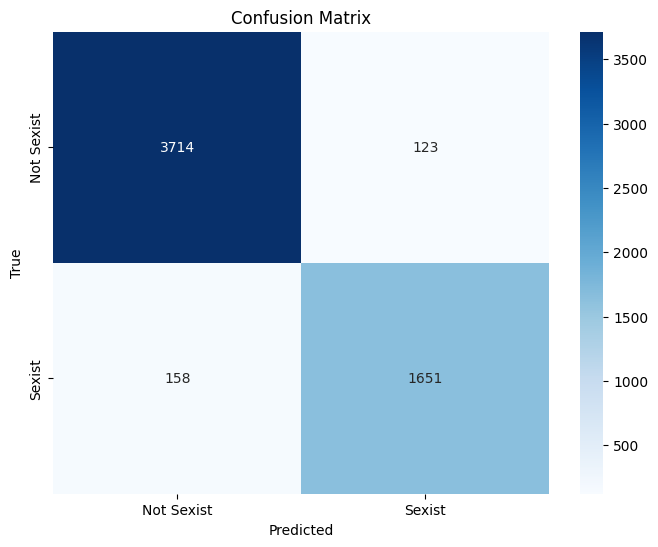

In [15]:
# Calcular y visualizar la matriz de confusión en el conjunto de prueba
conf_matrix = confusion_matrix(y_test, predictions_with_annotations)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sexist', 'Sexist'], yticklabels=['Not Sexist', 'Sexist'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

*La fusión de datos agregó las anotaciones adicionales a los textos originales, pero si la información de las anotaciones no introduce diferencias significativas en el modelo de regresión logística, se obtienen resultados similares.*

BERT con Hugging Face Pytorch

In [ ]:
#pip install accelerate==0.20.1
!pip install accelerate -U

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import torch

# Cargar el conjunto de datos original
original_data_df = pd.read_csv('sexism_data.csv')

# Cargar el conjunto de datos de anotaciones
annotations_df = pd.read_csv('sexism_annotations.csv')

# Conservar solo las columnas relevantes para nuestro modelo
annotations_df = annotations_df[['id', 'phrasing', 'content']]

# Fusionar los conjuntos de datos de datos y anotaciones usando la columna "id"
merged_df = pd.merge(original_data_df, annotations_df, on='id', how='inner')

# Resetear índices para evitar problemas con reindexación
merged_df.reset_index(drop=True, inplace=True)

# Dividir el conjunto de datos fusionado en entrenamiento y prueba
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42, stratify=merged_df['sexist'])

# Tokenizador BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Codificación de textos
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True)

# Preparar conjuntos de datos
class SexismDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels.iloc[idx]))
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SexismDataset(train_encodings, train_df['sexist'])
test_dataset = SexismDataset(test_encodings, test_df['sexist'])

# Modelo BERT para clasificación binaria
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Parámetros de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Entrenamiento del modelo con Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

# Predicciones en el conjunto de prueba
predictions = trainer.predict(test_dataset).predictions.argmax(axis=1)

# Evaluar el rendimiento del modelo
accuracy_score(test_df['sexist'].values, predictions)

print(f'Accuracy on test set with BERT: {accuracy:.2f}')

# Mostrar métricas detalladas
print(classification_report(test_df['sexist'], predictions, target_names=['Not Sexist', 'Sexist']))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.486400
1000,0.365100
1500,0.312100
2000,0.265300
2500,0.208100
3000,0.174500
3500,0.126500
4000,0.100000
4500,0.067700
5000,0.070200


Accuracy on test set with BERT: 0.91
              precision    recall  f1-score   support

  Not Sexist       1.00      1.00      1.00      3837
      Sexist       0.99      1.00      1.00      1809

    accuracy                           1.00      5646
   macro avg       1.00      1.00      1.00      5646
weighted avg       1.00      1.00      1.00      5646



In [ ]:
from torch.utils.data import DataLoader

# Suponiendo que ya has definido tu train_dataset y test_dataset
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Verificar dimensiones antes de entrenar
for batch in train_dataloader:
    inputs = batch['input_ids']
    labels = batch['labels']
    print(inputs.shape, labels.shape)